Performing visualisations and calculations to understand the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import the data and prep
crack_spread_df = pd.read_csv(r'../data/processed/crack_spread.csv')
crack_spread_df['date'] = pd.to_datetime(crack_spread_df['date'])
crack_spread_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    4177 non-null   int64         
 1   date          4177 non-null   datetime64[ns]
 2   close_crude   4177 non-null   float64       
 3   close_gasoil  4177 non-null   float64       
 4   crack_spread  4177 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 163.3 KB


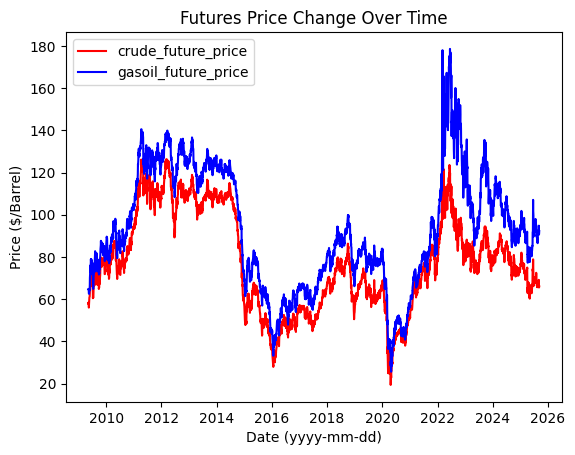

In [3]:
# visualise the trend between close prices
plt.plot(crack_spread_df['date'], crack_spread_df['close_crude'], label='crude_future_price', color='red')
plt.plot(crack_spread_df['date'], crack_spread_df['close_gasoil'], label='gasoil_future_price', color='blue')
plt.title('Futures Price Change Over Time')
plt.xlabel('Date (yyyy-mm-dd)')
plt.ylabel('Price ($/Barrel)')
plt.legend()
plt.show()

In [4]:
#TODO: Calculation/smth to statistically describe how closely they follow each other and then a markdown explaining it

Now let's plot the crack spread width to see how it changes over time

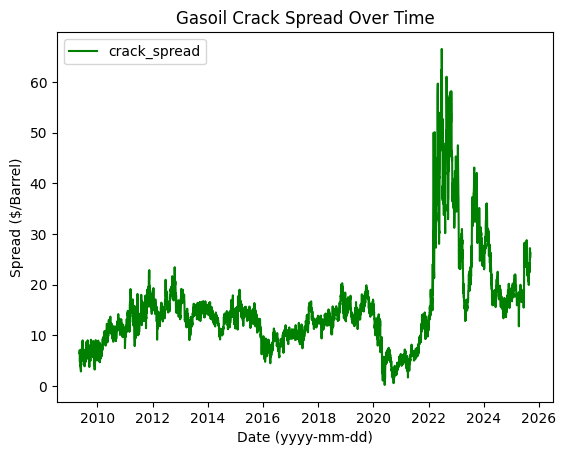

In [5]:
# plot the spread to visualise
plt.plot(crack_spread_df['date'], crack_spread_df['crack_spread'], label='crack_spread', color='green')

plt.title('Gasoil Crack Spread Over Time')
plt.xlabel('Date (yyyy-mm-dd)')
plt.ylabel('Spread ($/Barrel)')
plt.legend()
plt.show()

Let's put a moving average to smooth out the data (technically this is not as needed if we do serasonal decomp but still nice to look at initially)

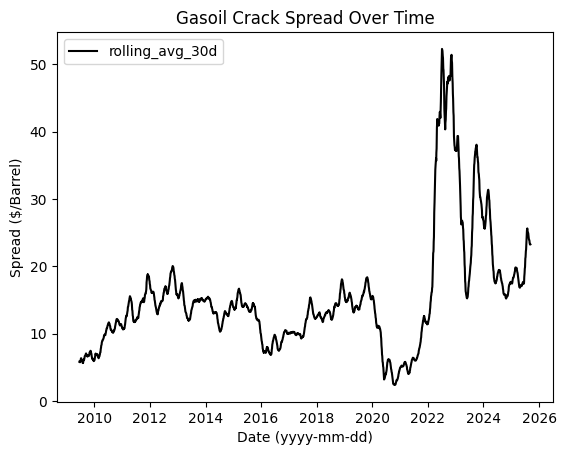

In [6]:
crack_spread_df['spread_rolling_avg_30d'] = crack_spread_df['crack_spread'].rolling(window=30).mean()

#plt.plot(crack_spread_df['date'], crack_spread_df['crack_spread'], label='crack_spread', color='green')
plt.plot(crack_spread_df['date'], crack_spread_df['spread_rolling_avg_30d'], label='rolling_avg_30d', color='black')

plt.title('Gasoil Crack Spread Over Time')
plt.xlabel('Date (yyyy-mm-dd)')
plt.ylabel('Spread ($/Barrel)')
plt.legend()
plt.show()

Plotting a histogram will give us an idea of the distribution of the spread over time. 

<function matplotlib.pyplot.show(close=None, block=None)>

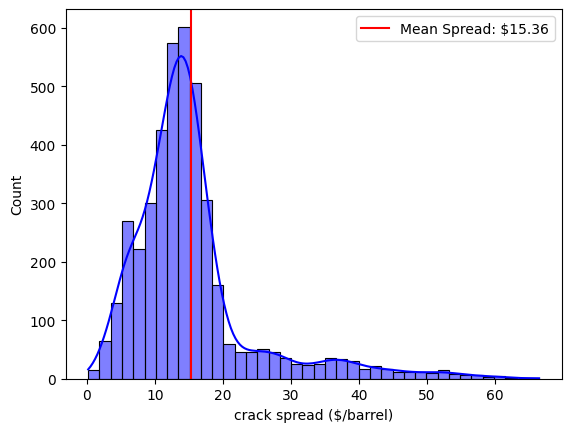

In [7]:
#TODO: Change this to a seasonal decomposition plot and later do a C
sns.histplot(data=crack_spread_df, x='crack_spread', bins=40, kde=True, color='blue')
plt.axvline(crack_spread_df['crack_spread'].mean(), color='red', label=f'Mean Spread: ${crack_spread_df["crack_spread"].mean():.2f}')
plt.xlabel('crack spread ($/barrel)')
plt.legend()
plt.show

Now we'll perform a seasonal decomposition test followed by a stationarity test with ADF test to see suitability of forecasting model

In [8]:
# to use statsmodel's seasonal_decompose, we need to augment the DF to index by day and only use the crack_spread
augmented_crack_spread_df = crack_spread_df[['date', 'crack_spread']]
augmented_crack_spread_df.set_index('date', inplace=True)
#augmented_crack_spread_df

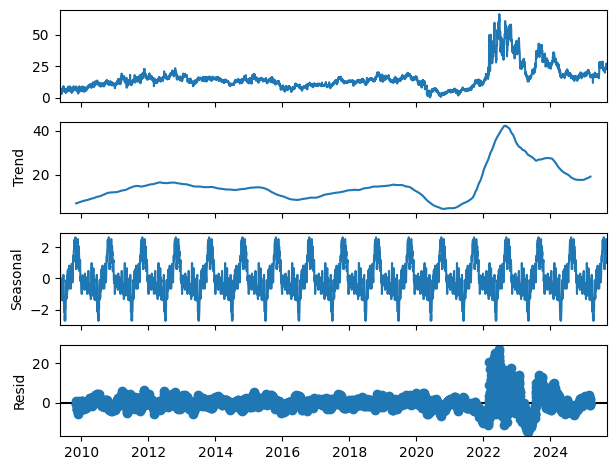

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
# now we perform the seasonal decomposition test (this is on daily data)
seasonal_decompose_result = seasonal_decompose(augmented_crack_spread_df, model='additive', period=252)
seasonal_decompaose_graph = seasonal_decompose_result.plot()

The seasonal decomposition has provided us with lots of insights. 

First with **trend** and **noise**:
- Between 2010 and 2020, the trend is fairly flat and stable. Noise is fairly constant too.
- Between 2020 and 2021, the trend dips sharply. This likely corresponds to Covid-19.
- Between 2022 and 2023, the war and its resultant gas pipeline disturbances caused huge spike in spread gap due to higher demand for gasoil. This is also immediately after Covid, companies want to recover their losses and thus have a huge demand for refined products which there's simply limited supply of. Thus widening the gap.

- N.B. Between the 2020 and 2023 period, noise is huge due to the uncertainty and instability of infrastructure and events.
- Post 2023, its dipping back down potentially returning to normal levels BUT crucially its still a higher spread than pre-2020. And according to the noise its still not super stable, although its returning.

Next with **seasonal** - This is crucial since it can tell us about appropriate forecasting models:
- Observe the entire plot, it looks like one massive repeating pattern.
- Narrowing the scope down to a year, the spread tightens in summer due to lower demand for refined products whilst in winter, it spikes very high due to more demand (since its cold to heat up houses etc.)

Hence, we can conclude the data is indeed seasonal. We should conduct an ADF test to check stationarity. For now a SARIMA model would work (given the data is stationary which I feel it wont be)

Now we'll perform an augemented Dickey-Fuller test. For our null hypothesis we assume the time series has a unit root (which makes it non-stationary). And our alternative hypothesis is it is stationary. We will observe the p-value at $\alpha = 0.05$

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
adf_result = adfuller(crack_spread_df['crack_spread'])
adf_result

(np.float64(-2.540872160115842),
 np.float64(0.10584367567593611),
 28,
 4148,
 {'1%': np.float64(-3.431927471404566),
  '5%': np.float64(-2.862237040274829),
  '10%': np.float64(-2.5671410407892545)},
 np.float64(15004.570291680053))

As can be seen, the p-value = 0.106. This is not less than $\alpha = 0.05$. Thus we conclude at the 5% significance level that we do not reject the null hypothesis and that the data is indeed non-stationary.

Since the data is non-stationary, if we want to fit a stationary model, we can use the method of differencing to acheive stationarity.  

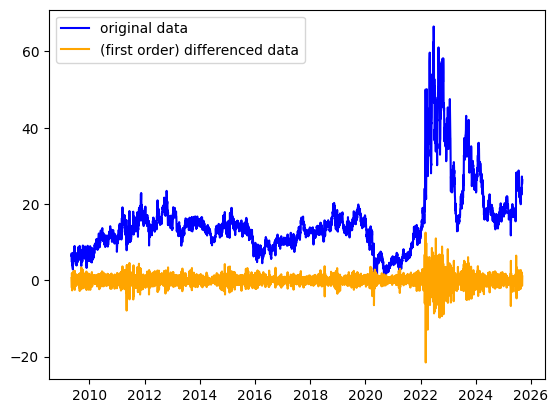

In [12]:
plt.plot(augmented_crack_spread_df, label='original data', color='blue')
differenced_augmented_crack_spread_df = augmented_crack_spread_df.diff().dropna()
plt.plot(differenced_augmented_crack_spread_df['crack_spread'], label='(first order) differenced data', color='orange')

plt.legend()
plt.show()

Performing another ADF test on the first differenced data.

In [13]:
adfuller(differenced_augmented_crack_spread_df['crack_spread'])

(np.float64(-14.531379487124532),
 np.float64(5.3245901536520244e-27),
 27,
 4148,
 {'1%': np.float64(-3.431927471404566),
  '5%': np.float64(-2.862237040274829),
  '10%': np.float64(-2.5671410407892545)},
 np.float64(15004.91847340293))

As can be seen visually by the graph as well as the ADF test, we can reject the null hypothesis on the 1st order difference data and conclude the differenced data is now stationary.

Based on our observations of seasonality, as well as converting the data into stationary data, we can now use ACF and PACF to determine the model we'd like to use. We will also potentially incorporate exogenous variables afterewards such as gasoil inventory levels within the model.

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

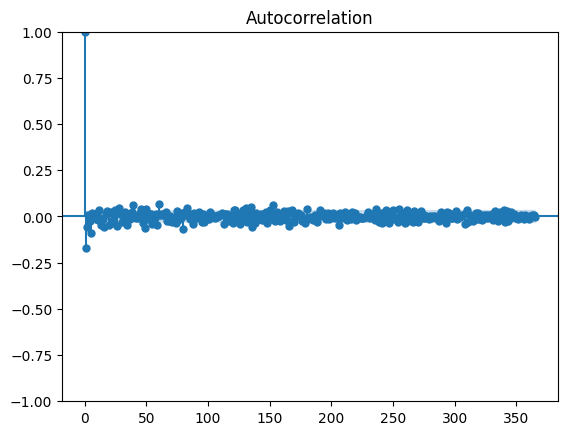

In [27]:
acf_graph = plot_acf(differenced_augmented_crack_spread_df['crack_spread'], lags=365)

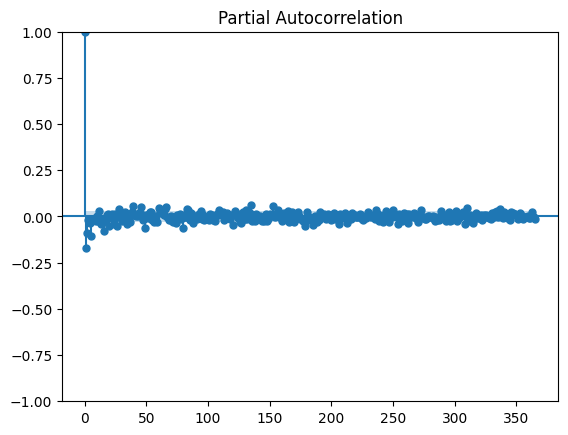

In [28]:
pacf_graph = plot_pacf(differenced_augmented_crack_spread_df['crack_spread'], lags=365)

Based on the plots of the Auto-Correlation Function (ACF) and Partial Auto-correlation Function (PACF) for the differenced data, we can determine the appropriate parameters for our SARIMA model.

#### **Non-Seasonal Parameters (p, d, q)**

* Both the ACF and PACF plots show a single, statistically significant spike at **lag 1**, after which the correlations immediately cut off and remain within the confidence interval.
* When both plots exhibit this sharp cutoff, it strongly suggests an **ARMA(1,1)** process for the differenced data. Therefore, we select `p=1` for the Autoregressive (AR) term and `q=1` for the Moving Average (MA) term.
* Combined with the first-order differencing (`d=1`) used to make the data stationary, our non-seasonal model component is **ARIMA(1, 1, 1)**.

#### **Seasonal Parameters (P, D, Q, m)**

While the initial seasonal decomposition plot revealed a clear yearly seasonality, a **first-order standard difference** made the series stationary. However...

* After observing the ACF and PACF plots of this differenced data, there are **no significant spikes at the seasonal lag of 252**.
* This indicates that the standard differencing removed not only the trend but also the seasonal component from the data.
* Because there is no remaining seasonality in the differenced data, we do not need to include a seasonal component in the model. Therefore, we set the seasonal parameters to zero: **`P=0`, `D=0`, and `Q=0`**.

This leads us to a final proposed baseline model of **SARIMA(1, 1, 1)(0, 0, 0)₂₅₂**. Or in other words, an **ARIMA(1,1,1)** model.

#### **EDA Findings** 

1.  **Non-Stationarity:** The first thing we noticed from the plots is that the crack spread has a clear trend and a yearly seasonal pattern. The ACF plot of the raw data confirmed this, showing correlations that died off very slowly, which is a  sign of non-stationarity. A formal ADF test proved this statistically (p-value > 0.05), implying we had to make the data stationary.

2.  **First-Order Differencing:** We applied a first-order difference to the data. This successfully removed the trend and seasonality, making the series stationary. The follow-up ADF test confirmed this with a very low p-value.

3.  **ACF/PACF for Parameter Approximation:** Once the data was stationary, we used the ACF and PACF plots to figure out the model structure. Both plots showed a clear, sharp cutoff after **lag 1**, which is a strong signal for an **ARMA(1,1)** process.

4. **Non-Seasonality:** Despite the seasonal decomposition plot showing clear seasonality, in the stationary data according to the ACF and PACF plots, the seasonality no longer existed. Thus, we no longer needed to model it shifting our model focus from a SARIMA to an ARIMA model.

#### **Baseline Model: ARIMA(1, 1, 1)**

Based on these findings, we have everything we need for a solid baseline model. We are using an **ARIMA model** because it's designed to handle non-stationary data by differencing it internally.

The parameters for our model, **ARIMA(p, d, q)**, are:

* **p = 1 (AR term):** From the PACF plot's cutoff after lag 1.
* **d = 1 (Differencing):** Because we needed one difference to make the series stationary.
* **q = 1 (MA term):** From the ACF plot's cutoff after lag 1.

So, our starting point for forecasting will be a simple but powerful **ARIMA(1, 1, 1)** model. Since the standard differencing removed the seasonality, we don't need the extra complexity of seasonal terms (P, D, Q) for this baseline attempt.